# Aircraft Crashes Data Clustering

## Overview

This notebook explores different clustering algorithms and compares the different results. The data has already been cleaned in the [EDA phase](data_analysis.ipynb).

## Data Preprocessing

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from yellowbrick.cluster import KElbowVisualizer

In [365]:
# Load data
with open('data/crashes_cleaned_data.pkl', 'rb') as handle:
	df = pickle.load(handle)
df.head()

,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
0,1970-01-02,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951,Multi Piston Engines,Unknown,Landing (descent or approach),Cargo,Mountains,"Long Tieng, Vientiane Province",Laos,Asia,20.017111,103.378253,Destroyed,4,4,0
1,1970-01-02,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0
2,1970-01-03,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0
3,1970-01-05,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0
4,1970-01-05,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0


In [366]:
# Split date in three columns
df.insert(0, 'year', df['date'].dt.year)
df.insert(1, 'month', df['date'].dt.month)
df.insert(2, 'day', df['date'].dt.day)
df = df.drop('date', axis=1)
df.head()

,year,month,day,category,type,operator,yom,engine,engine_model,flight_phase,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
0,1970,1,2,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951,Multi Piston Engines,Unknown,Landing (descent or approach),...,Mountains,"Long Tieng, Vientiane Province",Laos,Asia,20.017111,103.378253,Destroyed,4,4,0
1,1970,1,2,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),...,Airport (less than 10 km from airport),"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0
2,1970,1,3,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),...,Airport (less than 10 km from airport),"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0
3,1970,1,5,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),...,Airport (less than 10 km from airport),"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0
4,1970,1,5,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),...,Airport (less than 10 km from airport),"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0


### Reduce cardinality of string values

In [367]:
# Non-categorical columns
nb_unique = df.select_dtypes(include=['object']).nunique()
string_columns = nb_unique[nb_unique > 5].index
string_columns

Index(['type', 'operator', 'engine_model', 'flight_phase', 'flight_type',
       'site', 'location', 'country', 'region'],
      dtype='object')

In [368]:
for column in string_columns:
  values = list(df[column].value_counts().head(4).index)
  df[column] = np.where(df[column].isin(values), df[column], 'Other')

### Une Ordinal Encoding for category columns

In [369]:
cat_columns = df.select_dtypes(include=['category']).columns
ordinal_encoder = OrdinalEncoder()
encoded_cols = ordinal_encoder.fit_transform(df[cat_columns])
new_df = pd.DataFrame(encoded_cols, columns=ordinal_encoder.get_feature_names_out())
df = df.drop(columns=cat_columns, axis=1).join(new_df)

In [370]:
# Use One Hot Encoding for other columns
string_columns = df.select_dtypes(include=['object']).columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = onehot_encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out())
df = df.drop(columns=string_columns, axis=1).join(new_df)

In [371]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [ ]:
# Export data
df.to_csv('data/preprocessed_data.csv', index=False)

## Feature Engineering

In [373]:
df.shape

(13618, 48)

In [374]:
X = df.copy()

In [375]:
# Use PCA to reduce dimensionality to half
pca = PCA(n_components=24, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

In [376]:
X_pca = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23
0,1.474506,-0.620430,-0.121152,1.655477,-0.214181,0.391639,-1.590400,0.596145,-1.497904,-0.762146,...,0.395732,-0.823446,-1.645365,-0.529776,1.529281,1.655501,-0.436372,-0.377870,0.253500,-0.632526
1,-0.851107,-0.251284,-0.193392,1.810410,-0.495101,0.694801,-1.495114,0.664701,-1.478032,-1.165968,...,0.253455,-0.444247,-1.692016,0.197777,0.089309,-0.571674,-0.377783,-0.545478,-0.428669,-0.420735
2,1.546774,-0.660437,0.197410,1.531549,-0.441942,0.103191,-1.517979,0.471004,-1.486708,1.363442,...,1.444150,0.556590,-0.183021,-0.660448,-0.505807,-0.512795,0.262323,0.077929,1.206558,-1.028964
3,0.083206,0.744392,-0.107923,0.838465,-1.583277,-1.085997,-1.430031,0.633101,-1.518603,-0.639038,...,-0.173471,-1.555363,-0.807082,-0.315634,0.650058,-1.028302,-0.962570,-0.789881,-1.035968,0.192119
4,0.404175,-0.212224,-1.435405,1.100719,-0.221460,-0.486223,-1.366309,0.668979,-1.517267,-1.118811,...,-0.508955,2.576106,-0.603111,-0.904389,0.824516,-1.101262,-0.297369,0.027832,-0.049460,-0.570157


In [377]:
# Export data
X_pca.to_csv('data/pca_preprocessed_data.csv', index=False)

## Data Modeling

### K-Means

#### Find clusters

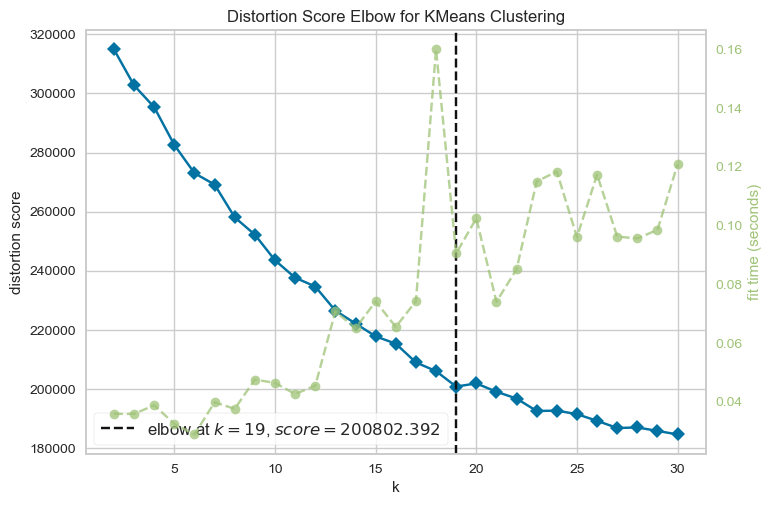

In [378]:
# SSD plot
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=30)
visualizer.fit(X_pca)
visualizer.show();

In [379]:
# Create multiple models for silhouette score
k_values = []
scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    k_values.append(k)
    scores.append(silhouette_score(X_pca, kmeans.labels_, metric='euclidean'))

models = pd.Series(data=scores, index=k_values)

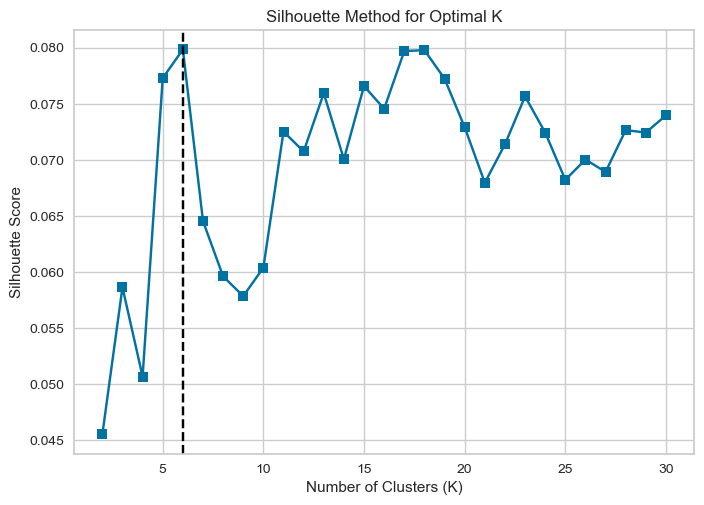

In [380]:
# Silhouette score plot
plt.plot(models, marker='s')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.axvline(x=models.idxmax(), color='black', linestyle='--')
plt.show()

In [381]:
models.nlargest(n=5)

6     0.079848
18    0.079789
17    0.079706
5     0.077289
19    0.077246
dtype: float64

In [394]:
# Based on the silhouette method, the lowest k value would be 6
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=42)

In [395]:
original_df = pd.read_csv('data/crashes_cleaned_data.csv', parse_dates=['date'])
original_df.insert(0, 'year', original_df['date'].dt.year)
original_df.insert(1, 'month', original_df['date'].dt.month)
original_df.insert(2, 'day', original_df['date'].dt.day)
original_df.insert(0, 'cluster_1', kmeans.labels_)
original_df = original_df.drop('date', axis=1)

#### Analyse the clusters

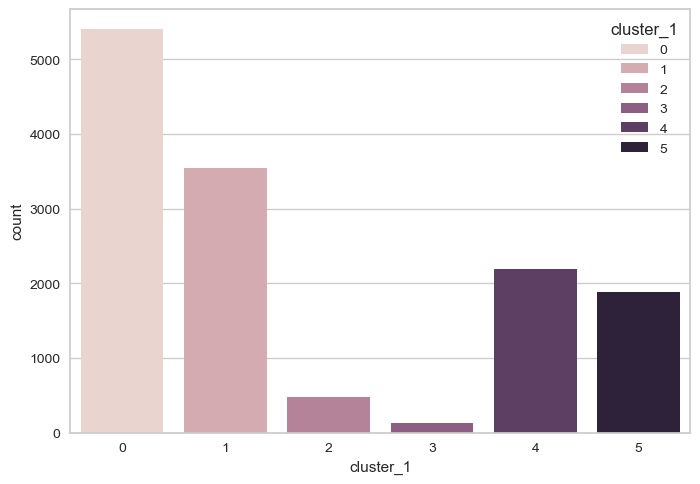

In [396]:
sns.countplot(data=original_df, x='cluster_1', hue='cluster_1');

In [398]:
cluster0 = original_df[original_df['cluster_1'] == 0]
cluster0.sample(10)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
12411,0,2015,8,23,Unknown,De Havilland DHC-2 Beaver,Air Saguenay,1958,Unknown,Unknown,...,"Plain, Valley","Les Bergeronnes, Quebec",Canada,North America,48.243882,-69.545517,Unknown,6,6,0
5190,0,1985,6,19,Unknown,Swearingen SA26T Merlin II,Telco Systems,1968,Unknown,Unknown,...,"Plain, Valley","Rocksprings, Texas",United States of America,North America,30.016687,-100.208556,Unknown,1,1,0
5221,0,1985,7,19,Unknown,Cessna 421C Golden Eagle III,HMGS,1976,Unknown,Unknown,...,Airport (less than 10 km from airport),"Kennesaw, Georgia",United States of America,North America,34.023434,-84.615490,Unknown,5,1,0
6978,0,1991,5,8,Accident,De Havilland DHC-3 Otter,Harbour Air Seaplanes,1959,1 Piston engine,Unknown,...,"Plain, Valley","Cameron Lake, British Columbia",Canada,North America,49.292746,-124.625424,Substantial,11,0,0
5796,0,1987,7,4,Unknown,Beechcraft D18,Imitari Athol North Aero,1945,Unknown,Unknown,...,"Plain, Valley","Lakeside, Montana",United States of America,North America,48.016795,-114.236892,Unknown,10,10,0
9169,0,1999,6,25,Accident,De Havilland DHC-3 Otter,Blue Water Aviation - Manitoba Air Charter Ser...,1955,1 Piston engine,Shvetsov ASh-62IR-M18,...,"Plain, Valley","Long Haul Lake, Manitoba",Canada,North America,61.066692,-107.991707,"Substantial, repaired",2,1,0
2586,0,1977,8,31,Unknown,Beechcraft C-45 Expeditor,Johnston Airways,1953,Unknown,Unknown,...,Airport (less than 10 km from airport),"Detroit-Willow Run (Ypsilanti), Michigan",United States of America,North America,42.218639,-83.536999,Unknown,1,1,0
5189,0,1985,6,19,Accident,Convair T-29,Combs FreightAir,1953,Multi Piston Engines,Pratt & Whitney R-2800-CB3,...,Airport (less than 10 km from airport),"Trenton-Mercer, New Jersey",United States of America,North America,40.220307,-74.765900,Destroyed,2,0,0
6349,0,1989,3,31,Unknown,Piper PA-61 Aerostar (Ted Smith 601),Richardson's Jewellery,1978,Unknown,Unknown,...,Airport (less than 10 km from airport),"Santa Ana-John Wayne, California",United States of America,North America,33.674205,-117.868024,Unknown,5,5,0
7163,0,1992,1,2,Unknown,Piper PA-31-310 Navajo,Becher Hoppe Engineers,1975,Unknown,Unknown,...,Airport (less than 10 km from airport),"Mosinee, Wisconsin",United States of America,North America,44.792767,-89.703075,Unknown,1,1,0


In [399]:
cluster0.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,5400.0,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000
mean,0.0,1992.156852,6.626111,15.727407,1970.955926,39.084029,-100.252304,5.480926,2.459074,0.043889
std,0.0,14.886196,3.505086,8.838435,14.928437,11.540648,22.089236,12.521824,5.874355,0.942759
min,0.0,1970.000000,1.000000,1.000000,1927.000000,-19.996972,-179.491343,0.000000,0.000000,0.000000
25%,0.0,1979.000000,4.000000,8.000000,1961.000000,32.932260,-111.939521,2.000000,0.000000,0.000000
50%,0.0,1990.000000,7.000000,16.000000,1972.000000,39.546638,-98.752281,3.000000,1.000000,0.000000
75%,0.0,2003.000000,10.000000,23.000000,1979.000000,43.547601,-83.028882,5.000000,3.000000,0.000000
max,0.0,2025.000000,12.000000,31.000000,2022.000000,79.990159,-37.116877,189.000000,111.000000,54.000000


In [400]:
cluster0.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400,5400
unique,5,357,3764,7,443,6,32,7,3121,21,7,7
top,Unknown,De Havilland DHC-2 Beaver,Private American,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Pacific Ocean, All World",United States of America,North America,Unknown
freq,3369,183,134,3598,3877,2426,1228,3105,34,4061,4691,3350


In [401]:
cluster1 = original_df[original_df['cluster_1'] == 1]
cluster1.sample(5)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
13493,1,2024,2,9,Accident,McDonnell Douglas MD-82,African Express Airways,1984,Multi Jet Engines,P&W JT8D-200,...,Airport (less than 10 km from airport),"Malakal, Upper Nile (أعالي النيل)",South Sudan,Africa,9.181377,32.193938,Substantial,2,0,0
5779,1,1987,6,19,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1983,Unknown,Unknown,...,"Plain, Valley","Leninsky, Kostanay",Kazakhstan,Asia,48.101295,66.778082,Unknown,2,1,0
5901,1,1987,10,21,Unknown,Max Holste M.H.1521M Broussard,French Air Force - Armée de l'Air,1960,Unknown,Unknown,...,Mountains,"Asinao Pass, Haute-Corse",France,Europe,41.849386,9.232516,Unknown,3,3,0
11477,1,2010,5,4,Unknown,Antonov AN-2,Proskurov Avia,1991,Unknown,Unknown,...,"Plain, Valley","Marianivka, Odessa Oblast",Ukraine,Europe,47.123517,30.966434,Unknown,2,0,0
8528,1,1996,11,13,Unknown,Piper PA-31-310 Navajo,Kissimayu Aviation,1969,Unknown,Unknown,...,Mountains,"Ngong, Kajiado",Kenya,Africa,-1.366600,36.650000,Unknown,8,8,0


In [402]:
cluster1.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,3539.0,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000
mean,1.0,1992.636055,6.527833,16.108788,1974.553264,30.497572,23.609974,8.771687,4.045493,0.186776
std,0.0,14.636825,3.435673,8.818135,13.471037,25.208500,19.710897,12.768313,8.401521,5.170019
min,1.0,1970.000000,1.000000,1.000000,1900.000000,-34.183202,-23.119354,0.000000,0.000000,0.000000
25%,1.0,1980.000000,4.000000,9.000000,1967.000000,9.181377,8.462817,2.000000,0.000000,0.000000
50%,1.0,1991.000000,7.000000,16.000000,1974.000000,41.471826,23.822264,4.000000,1.000000,0.000000
75%,1.0,2004.000000,9.000000,24.000000,1982.000000,49.487197,36.446324,9.000000,4.000000,0.000000
max,1.0,2025.000000,12.000000,31.000000,2022.000000,80.916649,72.398911,78.000000,63.000000,297.000000


In [403]:
cluster1.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,3539,3539,3539,3539,3539,3539,3539,3539,3539,3539,3539,3539
unique,4,346,1746,6,325,6,31,7,2252,122,5,7
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Kinshasa-N'Djili, Kinshasa City Province",Russia,Europe,Destroyed
freq,2140,442,392,1403,2166,1564,728,2024,25,310,1524,1996


In [404]:
cluster2 = original_df[original_df['cluster_1'] == 2]
cluster2.sample(5)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
12857,2,2018,9,1,Accident,Boeing 737-800,UTAir,2002,Multi Jet Engines,CFMI CFM56-7B26,...,Airport (less than 10 km from airport),"Sochi-Adler, Krasnodar Krai",Russia,Asia,43.443971,39.940093,Destroyed,170,0,0
1055,2,1973,2,24,Accident,Ilyushin II-18,Aeroflot - Russian International Airlines,1959,Multi Turboprop Engines,Ivchenko AI-20K,...,"Plain, Valley","Leninabad, Sughd Province",Tajikistan,Asia,40.284419,69.619167,Destroyed,79,79,0
11181,2,2008,9,14,Accident,Boeing 737-500,Aeroflot Nord,1992,Multi Jet Engines,CFMI CFM56-3C1,...,"Plain, Valley","Perm, Perm Krai",Russia,Asia,58.014965,56.246723,Destroyed,88,88,0
8800,2,1997,12,19,Unknown,Boeing 737-300,Silkair,1997,Multi Jet Engines,CFMI CFM56-3B2,...,"Plain, Valley","Palembang, South Sumatra",Indonesia,Asia,-2.988824,104.756851,Destroyed,104,104,0
9758,2,2001,12,20,Accident,Lockheed C-130 Hercules,Indonesian Air Force - TNI-AU Tentara Nasional...,1979,Multi Turboprop Engines,Allison 501-D22A,...,Airport (less than 10 km from airport),"Lhokseumawe-Malikussaleh, Aceh",Indonesia,Asia,5.183791,97.147371,Destroyed,95,0,0


In [405]:
cluster2.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,472.0,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,2.0,1994.680085,6.631356,15.688559,1980.705508,30.321488,50.928746,123.519068,36.485169,0.510593
std,0.0,14.709840,3.614625,8.872920,13.595933,19.535707,47.920199,48.176203,43.679831,4.693571
min,2.0,1970.000000,1.000000,1.000000,1944.000000,-26.136013,-118.242766,52.000000,0.000000,0.000000
25%,2.0,1982.000000,3.000000,8.000000,1971.000000,17.045454,20.205641,89.000000,0.000000,0.000000
50%,2.0,1994.000000,7.000000,16.000000,1979.000000,33.788406,46.879922,113.000000,3.000000,0.000000
75%,2.0,2007.000000,10.000000,23.000000,1990.000000,43.272686,88.626119,148.000000,75.250000,0.000000
max,2.0,2025.000000,12.000000,31.000000,2017.000000,69.371821,144.757709,340.000000,145.000000,78.000000


In [406]:
cluster2.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,472,472,472,472,472,472,472,472,472,472,472,472
unique,3,74,222,4,152,5,7,6,359,97,6,5
top,Accident,Boeing 737-200,Aeroflot - Russian International Airlines,Multi Jet Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Tehran-Mehrabad, Tehran City District",Russia,Asia,Destroyed
freq,421,51,63,389,69,315,397,362,6,59,301,355


In [407]:
cluster3 = original_df[original_df['cluster_1'] == 3]
cluster3.sample(5)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
2417,3,1977,3,27,Accident,Boeing 747-100,Pan American World Airways - PAA,1969,Multi Jet Engines,P&W JT9D-7A,...,Airport (less than 10 km from airport),"Tenerife-Norte-Los Rodeos, Canary Islands",Spain,Europe,28.487498,-16.345998,Destroyed,396,335,0
291,3,1970,11,27,Accident,Douglas DC-8,Capitol International Airways,1969,Multi Jet Engines,P&W JT3D,...,Airport (less than 10 km from airport),"Anchorage-Ted Stevens Intl, Alaska",United States of America,North America,61.181035,-149.997892,Destroyed,229,47,0
4163,3,1981,12,1,Accident,McDonnell Douglas MD-82,Inex-Adria Airways,1981,Multi Jet Engines,P&W JT8D-217,...,Mountains,"Mt San Pietro, Corse-du-Sud",France,Europe,46.603354,1.888334,Destroyed,180,180,0
12694,3,2017,6,7,Accident,Shaanxi Y-8,Myanmar Air Force - Tatmadaw Lei,2016,Multi Turboprop Engines,Zhuzhou WJ6,...,"Lake, Sea, Ocean, River","Andaman Sea, All World",World,World,33.974482,-118.269835,Destroyed,122,122,0
5928,3,1987,11,28,Accident,Boeing 747-200,South African Airways -SAA - Suid Afrikaanse L...,1980,Multi Jet Engines,P&W JT9D-7Q,...,"Lake, Sea, Ocean, River","Indian Ocean, All World",World,World,33.974482,-118.269835,Destroyed,159,159,0


In [408]:
cluster3.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,132.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,3.0,1992.378788,7.310606,16.469697,1981.272727,26.585726,-2.101363,210.553030,157.772727,1.143939
std,0.0,13.646312,3.285714,9.408815,13.423286,21.188402,75.471405,81.241353,84.781857,5.296020
min,3.0,1970.000000,1.000000,1.000000,1959.000000,-72.843869,-149.997892,107.000000,0.000000,0.000000
25%,3.0,1982.000000,5.000000,8.000000,1971.000000,13.326243,-73.779373,153.750000,124.500000,0.000000
50%,3.0,1991.000000,7.000000,17.500000,1978.500000,31.525814,2.312887,179.500000,155.500000,0.000000
75%,3.0,2001.250000,10.000000,25.000000,1989.000000,40.585148,47.295741,257.500000,189.500000,0.000000
max,3.0,2024.000000,12.000000,31.000000,2021.000000,78.223156,144.757709,524.000000,520.000000,45.000000


In [409]:
cluster3.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,132,132,132,132,132,132,132,132,132,132,132,132
unique,3,42,95,3,87,5,4,6,115,56,8,3
top,Accident,Boeing 727-200,Aeroflot - Russian International Airlines,Multi Jet Engines,P&W JT8D-9A,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Tenerife-Norte-Los Rodeos, Canary Islands",United States of America,Asia,Destroyed
freq,117,13,6,126,5,60,102,58,4,18,40,128


In [410]:
cluster4 = original_df[original_df['cluster_1'] == 4]
cluster4.sample(5)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
5129,4,1985,3,25,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1962,1 Piston engine,Unknown,...,Airport (less than 10 km from airport),"Borogon, Republic of Yakutia (Sakha)",Russia,Asia,64.686314,97.745306,Destroyed,3,0,0
8162,4,1995,7,1,Accident,Fokker F27 Friendship,East West Airlines - India,1980,Multi Turboprop Engines,Unknown,...,Airport (less than 10 km from airport),"Baroda (Vadodara), Gujarat",India,Asia,22.297314,73.194257,Destroyed,3,0,0
1716,4,1975,1,16,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1973,1 Piston engine,Unknown,...,Mountains,"Sam Neua, Houaphan Province",Laos,Asia,20.415151,104.047364,Destroyed,12,12,0
8784,4,1997,11,27,Accident,Britten-Norman Islander,Vanair,1970,Multi Piston Engines,Unknown,...,"Lake, Sea, Ocean, River","Sangafa-Siwo (Emae Island), All Vanuatu",Vanuatu,Oceania,-16.525507,168.106915,Substantial,3,0,0
4009,4,1981,6,7,Accident,Fokker F27 Friendship,Burma Airways,1966,Multi Turboprop Engines,Unknown,...,Airport (less than 10 km from airport),"Sandoway, Rakhine State (Arakan)",Myanmar,Asia,17.175050,95.999965,Destroyed,4,0,0


In [411]:
cluster4.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,2196.0,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000
mean,4.0,1990.358834,6.692623,16.192623,1973.141166,20.874487,115.015419,11.043260,5.068306,0.196266
std,0.0,14.650542,3.442963,8.896200,14.701715,32.706520,26.695395,15.262694,9.865837,4.099581
min,4.0,1970.000000,1.000000,1.000000,1934.000000,-43.535690,69.184908,0.000000,0.000000,0.000000
25%,4.0,1978.000000,4.000000,8.000000,1964.000000,-2.483383,97.745306,2.000000,0.000000,0.000000
50%,4.0,1989.000000,7.000000,16.000000,1972.000000,20.017111,107.965086,5.000000,1.000000,0.000000
75%,4.0,2001.000000,10.000000,24.000000,1981.000000,52.731927,134.755000,13.000000,5.000000,0.000000
max,4.0,2025.000000,12.000000,31.000000,2021.000000,79.493854,178.029725,95.000000,70.000000,180.000000


In [412]:
cluster4.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,2196,2196,2196,2196,2196,2196,2196,2196,2196,2196,2196,2196
unique,4,252,768,6,200,6,30,7,1455,42,5,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Manila-Ninoy Aquino, Metro Manila",Russia,Asia,Destroyed
freq,1305,291,385,865,1459,834,773,1047,18,611,1742,1203


In [413]:
cluster5 = original_df[original_df['cluster_1'] == 5]
cluster5.sample(5)

,cluster_1,year,month,day,category,type,operator,yom,engine,engine_model,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
7384,5,1992,10,23,Accident,Embraer C-95 Bandeirante,Brazilian Air Force - Força Aérea Brasileira (...,1977,Multi Turboprop Engines,P&W Canada PT6A,...,Airport (less than 10 km from airport),"Recife, Pernambuco",Brazil,South America,-8.058493,-34.884819,Destroyed,5,5,0
5308,5,1985,10,23,Unknown,Piper PA-31-310 Navajo,Transportes Aéreos Tropicales - TAT Colombia,1968,Unknown,Unknown,...,City,"Bogotá-El Dorado, Bogotá Capital District",Colombia,South America,4.610017,-74.069303,Unknown,5,5,0
996,5,1972,12,21,Accident,De Havilland DHC-6 Twin Otter,Air Guadeloupe,1969,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-27,...,"Lake, Sea, Ocean, River","Sint Maarten, Dutch Antilles",Dutch Antilles,Central America,12.184500,-68.660792,Destroyed,13,13,0
12720,5,2017,9,4,Unknown,BAe 125,Private Venezuela,1998,Unknown,Unknown,...,"Plain, Valley","Hato Viejo, Cojedes",Venezuela,South America,9.628253,-67.958915,Unknown,2,2,0
9702,5,2001,9,22,Accident,Britten-Norman Islander,Fundação Nacional do Índio - FUNAI,1976,Multi Piston Engines,Unknown,...,"Plain, Valley","Bujari, Acre",Brazil,South America,-9.830966,-67.952089,Destroyed,5,0,0


In [414]:
cluster5.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1879.0,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,5.0,1992.387972,6.560937,15.759447,1970.235232,-5.255384,-65.851161,11.769558,5.315061,0.185205
std,0.0,15.210104,3.495682,8.842585,16.319201,18.716428,12.694357,20.210174,11.599399,3.008468
min,5.0,1970.000000,1.000000,1.000000,1937.000000,-72.843869,-90.529021,0.000000,0.000000,0.000000
25%,5.0,1979.000000,3.000000,8.000000,1958.000000,-17.273827,-74.060793,2.000000,0.000000,0.000000
50%,5.0,1991.000000,7.000000,16.000000,1971.000000,-1.339767,-68.133623,5.000000,2.000000,0.000000
75%,5.0,2005.000000,10.000000,23.000000,1980.000000,8.559559,-60.417271,10.000000,5.000000,0.000000
max,5.0,2025.000000,12.000000,31.000000,2023.000000,42.367382,0.000000,149.000000,102.000000,110.000000


In [415]:
cluster5.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,1879,1879,1879,1879,1879,1879,1879,1879,1879,1879,1879,1879
unique,4,249,963,6,200,6,30,7,1097,47,6,6
top,Accident,Douglas C-47 Skytrain (DC-3),Brazilian Air Force - Força Aérea Brasileira (...,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Brazil,South America,Destroyed
freq,1125,107,52,785,1216,779,469,913,38,362,1485,1028


##### Observations

0. Mostly in North-America, in private smaller planes
1. Mostly in Europe, in smaller commercial planes, 
2. Mostly in Asia, in commercial bigger planes, lower fatality rate
3. Mostly in Asia, in commercial bigger planes, higher fatality rate
4. Eastern hemisphere, in commercial smaller planes
5. Mostly in South America, in smaller commercial planes

### Hierarchical Clustering

In [ ]:
# Dendogram

### DBSCAN

In [447]:
# Plot different proportion of outliers based on the epsilon value
# The minimum points per kluster will be the number of dimensions plus 1
models = []
min_samples = len(X_pca.columns) + 1

for eps in np.linspace(0.001, 6, 50):
	dbscan = DBSCAN(eps=eps, min_samples=min_samples)
	dbscan.fit(X_pca)

	unique, counts = np.unique(dbscan.labels_, return_counts=True)
	freqs = dict(zip(unique, counts))

	percentage = freqs[-1] / len(X_pca)
	
	models.append({'epsilon': eps, 'outliers': percentage})

models_df = pd.DataFrame(models)

In [456]:
models_df[models_df['outliers'] < 0.05]

,epsilon,outliers
32,3.918714,0.048245
33,4.041143,0.034954
34,4.163571,0.026582
35,4.286000,0.022323
36,4.408429,0.017624
37,4.530857,0.013218
38,4.653286,0.011088
39,4.775714,0.008224
40,4.898143,0.007049
41,5.020571,0.006168


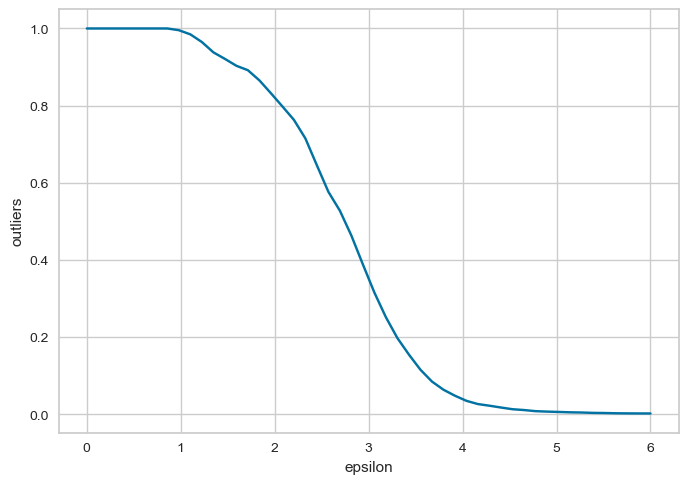

In [448]:
# Outlier points vs. eps value lineplot
sns.lineplot(data=models_df, x='epsilon', y='outliers');

In [484]:
# Based on the plot, a reasonable epsilon value would be 4 (where the "elbow" is)
model = DBSCAN(eps=4, min_samples=min_samples)
model.fit(X_pca)

DBSCAN(eps=4, min_samples=25)

In [485]:
# Add cluster to dataframe
#original_df.insert(1, 'cluster_2', model.labels_)
original_df['cluster_2'] = model.labels_

In [486]:
original_df.sample(5)

,cluster_1,cluster_2,year,month,day,category,type,operator,yom,engine,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
2580,0,0,1977,8,27,Unknown,Cessna 411,Terminal Ice & Cold Storage Company,1965,Unknown,...,"Lake, Sea, Ocean, River","Yakutat, Alaska",United States of America,North America,59.572735,-139.578312,Unknown,7,7,0
13499,1,0,2024,2,18,Unknown,PAC 750XL - Pacific Aerospace Corporation,Skydive Grenchen,2011,Unknown,...,Airport (less than 10 km from airport),"Grenchen, Solothurn",Switzerland,Europe,47.191150,7.396720,Unknown,1,1,0
584,1,0,1971,11,12,Accident,Antonov AN-24,Aeroflot - Russian International Airlines,1966,Multi Turboprop Engines,...,Airport (less than 10 km from airport),"Vinnitsa, Vinnytsia Oblast",Ukraine,Europe,49.239281,28.511062,Destroyed,48,48,0
2311,0,0,1976,12,16,Accident,Convair CV-880,Air Trine,1961,Multi Jet Engines,...,Airport (less than 10 km from airport),"Miami-Intl, Florida",United States of America,North America,25.794979,-80.286723,Destroyed,3,0,0
7456,1,0,1993,1,6,Accident,De Havilland DHC-8-300 (Dash-8),Lufthansa Cityline,1990,Multi Turboprop Engines,...,Airport (less than 10 km from airport),"Paris-Roissy-CDG, Val-d'Oise",France,Europe,48.999828,2.510367,Destroyed,23,4,0


In [487]:
original_df['cluster_2'].value_counts()

cluster_2
 0    12990
-1      535
 1       93
Name: count, dtype: int64

#### Analyse clusters

In [489]:
outliers = original_df[original_df['cluster_2'] == -1]
outliers.sample(5)

,cluster_1,cluster_2,year,month,day,category,type,operator,yom,engine,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
7819,1,-1,1994,4,6,Unlawful Interference,Dassault Falcon 50,Rwandese Government,1979,Multi Jet Engines,...,Airport (less than 10 km from airport),"Kigali, Kigali City",Rwanda,Africa,-1.950851,30.061507,Destroyed,12,12,0
4408,0,-1,1982,9,18,Accident,De Havilland DHC-3 Otter,Central Mountain Air Services,1965,1 Piston engine,...,Mountains,"Two Bridge Lake, British Columbia",Canada,North America,61.066692,-107.991707,Destroyed,5,5,0
2245,4,-1,1976,9,26,Unlawful Interference,Antonov AN-2,Aeroflot - Russian International Airlines,1961,1 Piston engine,...,City,"Novosibirsk, Novosibirsk oblast",Russia,Asia,54.967814,82.951599,Destroyed,1,1,4
12113,4,-1,2013,10,19,Accident,BAe 146,Skyjet Airlines,1985,Multi Jet Engines,...,"Lake, Sea, Ocean, River","Balesin, Quezon",Philippines,Asia,14.422339,122.038331,Substantial,75,0,0
6955,2,-1,1991,3,21,Accident,Lockheed C-130 Hercules,Royal Saudi Air Force (القوات الجوية الملكية ا...,1977,Multi Turboprop Engines,...,Airport (less than 10 km from airport),"Ras al-Mishab, ash-Sharqīyah (الشرقية‎)",Saudi Arabia,Asia,28.099360,48.611692,Destroyed,101,98,0


In [490]:
outliers.describe()

,cluster_1,cluster_2,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,535.000000,535.0,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,2.342056,-1.0,1993.097196,6.786916,15.699065,1974.325234,23.284430,0.210028,75.248598,44.758879,2.790654
std,1.675112,0.0,15.407507,3.558949,9.178479,17.440397,29.361672,81.811742,98.363500,75.671178,17.335236
min,0.000000,-1.0,1970.000000,1.000000,1.000000,1900.000000,-72.843869,-179.491343,0.000000,0.000000,0.000000
25%,1.000000,-1.0,1980.000000,3.000000,8.000000,1964.000000,3.587621,-72.832102,3.000000,0.000000,0.000000
50%,2.000000,-1.0,1991.000000,7.000000,16.000000,1974.000000,30.114050,9.964974,18.000000,3.000000,0.000000
75%,4.000000,-1.0,2005.000000,10.000000,24.000000,1985.000000,46.533240,51.168222,121.500000,69.500000,0.000000
max,5.000000,-1.0,2025.000000,12.000000,31.000000,2023.000000,70.614276,177.506092,524.000000,520.000000,297.000000


In [491]:
outliers.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,535,535,535,535,535,535,535,535,535,535,535,535
unique,3,136,390,6,195,6,24,7,468,118,9,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Multi Jet Engines,Unknown,Flight,Scheduled Revenue Flight,Airport (less than 10 km from airport),"Tenerife-Norte-Los Rodeos, Canary Islands",Russia,Asia,Destroyed
freq,325,38,40,255,156,174,228,211,5,58,167,424


In [492]:
group0 = original_df[original_df['cluster_2'] == 0]
group0.sample(5)

,cluster_1,cluster_2,year,month,day,category,type,operator,yom,engine,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
5328,0,0,1985,11,27,Unknown,Beechcraft 90 King Air,Jen Rob Aviation,1981,Unknown,...,"Plain, Valley","Warwick, Rhode Island",United States of America,North America,41.699272,-71.458611,Unknown,2,2,0
12650,0,0,2017,3,3,Unknown,Beechcraft G18S,Point to Point,1960,Unknown,...,"Lake, Sea, Ocean, River","Metlakatla, Alaska",United States of America,North America,55.119442,-131.574949,Unknown,2,0,0
9939,0,0,2002,10,3,Unknown,Piper PA-60 Aerostar (Ted Smith 600),Poke Aire,1981,Unknown,...,Airport (less than 10 km from airport),"Bradford, Pennsylvania",United States of America,North America,41.774668,-76.526461,Unknown,1,1,0
7695,4,0,1993,11,8,Accident,Harbin Yunsunji Y-12,Nepal Airways,1991,Multi Turboprop Engines,...,"Lake, Sea, Ocean, River","Jomsom, Dhawalagiri",Nepal,Asia,28.378046,83.999990,Destroyed,19,0,0
8120,0,0,1995,5,9,Unknown,Beechcraft 60 Duke,Leonard Schroetlin,1976,Unknown,...,Airport (less than 10 km from airport),"Olney-Noble, Illinois",United States of America,North America,38.720395,-88.171758,Unknown,2,2,0


In [493]:
group0.describe()

,cluster_1,cluster_2,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,12990.000000,12990.0,12990.000000,12990.000000,12990.000000,12990.000000,12990.000000,12990.000000,12990.000000,12990.000000,12990.000000
mean,1.661509,0.0,1992.146959,6.602309,15.919015,1972.556582,27.602583,-23.908248,11.715858,4.795920,0.044342
std,1.916066,0.0,14.805866,3.475700,8.836427,14.761996,25.694327,83.638706,25.853860,13.642573,0.497779
min,0.000000,0.0,1970.000000,1.000000,1.000000,1927.000000,-72.843869,-179.491343,0.000000,0.000000,0.000000
25%,0.000000,0.0,1979.000000,4.000000,8.000000,1964.000000,11.236191,-90.529021,2.000000,0.000000,0.000000
50%,1.000000,0.0,1990.000000,7.000000,16.000000,1973.000000,34.501293,-64.708057,4.000000,1.000000,0.000000
75%,4.000000,0.0,2004.000000,10.000000,23.000000,1981.000000,45.045698,35.216067,8.000000,4.000000,0.000000
max,5.000000,0.0,2025.000000,12.000000,31.000000,2022.000000,80.916649,178.029725,302.000000,200.000000,14.000000


In [494]:
group0.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,12990,12990,12990,12990,12990,12990,12990,12990,12990,12990,12990,12990
unique,5,489,6954,7,735,6,32,7,7843,205,9,7
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",United States of America,North America,Unknown
freq,6803,720,818,6646,8564,5801,2747,7277,35,4045,4650,6174


In [495]:
group1 = original_df[original_df['cluster_2'] == 1]
group1.sample(5)

,cluster_1,cluster_2,year,month,day,category,type,operator,yom,engine,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
1533,4,1,1974,7,15,Unknown,Douglas C-54 Skymaster,China Airlines,1944,Multi Piston Engines,...,Airport (less than 10 km from airport),"Battambang, Battambang",Cambodia,Asia,13.099853,103.196666,Destroyed,0,0,0
5277,1,1,1985,9,23,Unknown,Britten-Norman Islander,Angola Air Force - Força Aérea Nacional Angolana,1981,Multi Piston Engines,...,"Plain, Valley","Angola, All Angola",Angola,Africa,-11.877577,17.569124,Destroyed,0,0,0
9173,1,1,1999,7,1,Unlawful Interference,Antonov AN-12,Savanair,1968,Multi Turboprop Engines,...,"Plain, Valley","Luzamba, Lunda Norte",Angola,Africa,-9.147281,18.043102,Destroyed,5,1,0
3138,1,1,1979,1,23,Unknown,Lockheed C-130 Hercules,Italian Air Force - Aeronautica Militare Italiana,1973,Multi Turboprop Engines,...,Airport (less than 10 km from airport),"Milan-Malpensa, Lombardy",Italy,Europe,45.629627,8.723547,Destroyed,0,0,0
1737,4,1,1975,2,4,Unknown,Douglas C-47 Skytrain (DC-3),Indian Air Force - Bharatiya Vayu Sena,1956,Multi Piston Engines,...,Unknown,"India, All India",India,Asia,28.612933,77.229493,Destroyed,0,0,0


In [496]:
group1.describe()

,cluster_1,cluster_2,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,93.000000,93.0,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.0
mean,2.387097,1.0,1981.698925,6.537634,16.129032,1966.053763,18.887177,56.446757,7.021505,5.537634,0.0
std,1.532491,0.0,11.673814,3.367231,9.019575,11.481900,18.737271,48.071955,10.198016,9.374525,0.0
min,0.000000,1.0,1970.000000,1.000000,1.000000,1943.000000,-23.168178,-101.682977,0.000000,0.000000,0.0
25%,1.000000,1.0,1972.000000,4.000000,8.000000,1957.000000,8.769335,17.596147,0.000000,0.000000,0.0
50%,1.000000,1.0,1978.000000,7.000000,17.000000,1968.000000,20.017111,57.003690,4.000000,2.000000,0.0
75%,4.000000,1.0,1989.000000,9.000000,24.000000,1975.000000,31.574662,105.804397,9.000000,7.000000,0.0
max,5.000000,1.0,2022.000000,12.000000,31.000000,1997.000000,59.674971,144.248908,49.000000,49.000000,0.0


In [497]:
group1.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,93,93,93,93,93,93,93,93,93,93,93,93
unique,2,29,57,3,12,6,16,5,77,39,5,2
top,Unknown,Britten-Norman Islander,United States Air Force - USAF (since 1947),Multi Piston Engines,Unknown,Flight,Military,"Plain, Valley","India, All India",Vietnam,Asia,Destroyed
freq,74,18,14,46,72,52,38,45,6,14,53,92


#### Observations

-1: Mostly Russia, destroyed airplane, bigger planes, commercial flights
0: Unknown aircraft damage, smaller planes, commercial flights
1: Mostly military flights

### Compare the different clusterings

bla bla bla

## End